<a href="https://colab.research.google.com/github/sebauribeo/deteccionFraudes/blob/master/evaluacion_3_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *1.- Importación de Librerías y Carga de Datos*

En esta sección, importamos todas las librerías necesarias para el análisis de datos, preprocesamiento, modelado y evaluación. También cargamos el conjunto de datos que utilizaremos para entrenar y probar nuestro modelo.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de preprocesamiento y modelado
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Manejo del desbalance de clases
from imblearn.over_sampling import SMOTE

# Librerías de PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Carga de datos
data = pd.read_csv('/content/financial_dataset.csv')

# *2.- Preprocesamiento de Datos*
En esta sección, realizamos un análisis inicial de los datos, manejamos valores faltantes y codificamos variables categóricas. Creamos características adicionales que pueden ser útiles para el modelo y seleccionamos las características relevantes. Finalmente, estandarizamos los datos para prepararlos para el entrenamiento.
## a.- Exploración Inicial

In [2]:
# Visualizar las primeras filas del dataset
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


## b.- Manejo de Valores Faltantes

In [3]:
# Verificar valores faltantes en cada columna
print("Valores faltantes por columna:")
print(data.isnull().sum())

# Eliminar filas con valores faltantes en 'isFraud'
data = data.dropna(subset=['isFraud'])

# Opcional: También podemos eliminar filas con valores faltantes en las características
data = data.dropna()


Valores faltantes por columna:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


## c.- Codificación de Variables Categóricas

In [4]:
# Crear una instancia de LabelEncoder para codificar variables categóricas
label_encoder = LabelEncoder()

# Codificar la columna 'type' y agregarla como una nueva columna 'type_encoded'
data['type_encoded'] = label_encoder.fit_transform(data['type'])


## d.- Creación de Características Adicionales

In [5]:
# Crear características adicionales basadas en los balances
data['errorBalanceOrig'] = data['newbalanceOrig'] + data['amount'] - data['oldbalanceOrg']
data['errorBalanceDest'] = data['oldbalanceDest'] + data['amount'] - data['newbalanceDest']

## e.- Selección de Características Relevantes

In [6]:
# Definir las características que se utilizarán para entrenar el modelo
features = ['step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
            'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest']

# Crear la matriz de características 'X' y el vector objetivo 'y'
X = data[features]           # Características de entrada
y = data['isFraud']          # Variable objetivo (0: no fraude, 1: fraude)

## f.- Estandarización de Datos

In [7]:
# Crear una instancia de StandardScaler para estandarizar las características
scaler = StandardScaler()

# Ajustar el escalador a los datos y transformar las características
X_scaled = scaler.fit_transform(X)

# *3. Análisis Exploratorio de Datos (EDA)*
Realizamos un análisis exploratorio para entender mejor la distribución de las clases y visualizar posibles desequilibrios. Esto nos ayuda a decidir cómo manejar el desbalance de clases en las siguientes etapas.
## a.-Distribución de Clases

In [8]:
# Contar el número de transacciones fraudulentas y no fraudulentas
fraud_counts = data['isFraud'].value_counts()
print(fraud_counts)

isFraud
0.0    790684
1.0       458
Name: count, dtype: int64


## b.- Visualización de la Distribución

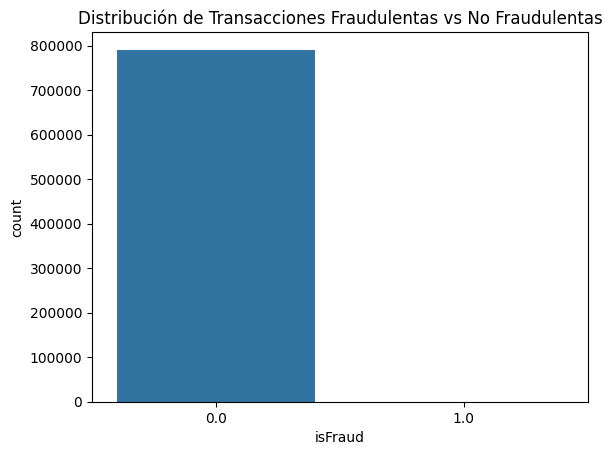

In [9]:
# Visualizar la distribución de transacciones fraudulentas
sns.countplot(x='isFraud', data=data)
plt.title('Distribución de Transacciones Fraudulentas vs No Fraudulentas')
plt.show()

# *4.- Manejo del Desbalance de Clases*
Debido a que las transacciones fraudulentas son significativamente menos frecuentes que las no fraudulentas, utilizamos la técnica SMOTE (Synthetic Minority Over-sampling Technique) para balancear las clases y mejorar la capacidad del modelo para detectar fraudes.

In [10]:
# Verificar si hay valores faltantes en y antes de aplicar SMOTE
print("Valores faltantes en y:", y.isnull().sum())

# Asegurarnos de que y no contenga valores faltantes
y = y.fillna(0)

# Crear una instancia de SMOTE para el sobremuestreo de la clase minoritaria
smote = SMOTE(random_state=42)

# Aplicar SMOTE para generar nuevas muestras sintéticas y balancear las clases
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

Valores faltantes en y: 0


# *5.- División del Conjunto de Datos*
Dividimos el conjunto de datos balanceado en conjuntos de entrenamiento y prueba. Esto nos permite entrenar el modelo en un subconjunto de los datos y luego evaluar su rendimiento en datos no vistos.

In [11]:
# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,           # Datos de entrada y objetivo balanceados
    test_size=0.2,                      # Proporción del conjunto de prueba (20%)
    random_state=42,                    # Semilla para reproducibilidad
    stratify=y_resampled                # Mantener la proporción de clases en la división
)

# *6.- Conversión a Tensores y Creación de DataLoaders*
Convertimos los conjuntos de datos en tensores de PyTorch y creamos DataLoaders para facilitar el proceso de entrenamiento en lotes (batches). Los DataLoaders permiten iterar sobre los datos en mini-lotes durante el entrenamiento.

In [12]:
# Convertir los datos de entrenamiento a tensores de tipo float32
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

# Convertir los datos de prueba a tensores
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Crear datasets de PyTorch a partir de los tensores
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Definir el tamaño del lote (batch size)
batch_size = 64

# Crear DataLoaders para cargar los datos en mini-lotes durante el entrenamiento
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# *7.- Definición del Modelo con PyTorch*
Definimos la arquitectura de la red neuronal utilizando PyTorch. El modelo consiste en una red neuronal profunda con varias capas lineales, funciones de activación ReLU y capas de Dropout para prevenir el sobreajuste.
## a.- Arquitectura del Modelo

In [13]:
# Definir una clase para el modelo de detección de fraudes
class FraudDetectionModel(nn.Module):
    def __init__(self):
        super(FraudDetectionModel, self).__init__()  # Inicializar la clase padre
        # Definir la arquitectura de la red neuronal
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),  # Capa de entrada a primera capa oculta con 64 neuronas
            nn.ReLU(),                        # Función de activación ReLU
            nn.Dropout(0.2),                  # Capa de Dropout con probabilidad de 0.2
            nn.Linear(64, 32),                # Primera a segunda capa oculta con 32 neuronas
            nn.ReLU(),                        # Función de activación ReLU
            nn.Dropout(0.2),                  # Capa de Dropout
            nn.Linear(32, 1),                 # Segunda capa oculta a capa de salida con 1 neurona
            nn.Sigmoid()                      # Función de activación Sigmoide para salida binaria
        )

    def forward(self, x):
        # Definir el paso hacia adelante (forward) del modelo
        return self.model(x)

## b.- Inicialización del Modelo, Pérdida y Optimizador

In [14]:
# Crear una instancia del modelo
model = FraudDetectionModel()

# Definir la función de pérdida (Binary Cross-Entropy Loss para clasificación binaria)
criterion = nn.BCELoss()

# Definir el optimizador (Adam) y la tasa de aprendizaje
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# *8.- Entrenamiento del Modelo*
Entrenamos el modelo en el conjunto de entrenamiento durante varias épocas. En cada época, el modelo ajusta sus pesos para minimizar la función de pérdida. También evaluamos el modelo en el conjunto de prueba después de cada época para monitorear su rendimiento.

In [15]:
# Definir el número de épocas para el entrenamiento
num_epochs = 10

# Listas para almacenar las pérdidas de entrenamiento y prueba en cada época
train_losses = []
test_losses = []

# Ciclo de entrenamiento a través de las épocas
for epoch in range(num_epochs):
    model.train()  # Establecer el modo de entrenamiento
    running_loss = 0.0  # Inicializar la pérdida acumulada de entrenamiento
    for features, labels in train_loader:
        # Paso hacia adelante: calcular las predicciones del modelo
        outputs = model(features)
        # Calcular la pérdida entre las predicciones y las etiquetas reales
        loss = criterion(outputs.view(-1), labels)

        # Paso hacia atrás: inicializar los gradientes y realizar backpropagation
        optimizer.zero_grad()  # Limpiar los gradientes previos
        loss.backward()        # Calcular gradientes
        optimizer.step()       # Actualizar los pesos del modelo

        # Acumular la pérdida de entrenamiento
        running_loss += loss.item()

    # Calcular la pérdida promedio de entrenamiento en la época actual
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)  # Guardar la pérdida de entrenamiento

    # Evaluación del modelo en el conjunto de prueba
    model.eval()  # Establecer el modo de evaluación
    test_loss = 0.0  # Inicializar la pérdida acumulada de prueba
    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for features, labels in test_loader:
            outputs = model(features)  # Obtener las predicciones
            loss = criterion(outputs.view(-1), labels)  # Calcular la pérdida
            test_loss += loss.item()  # Acumular la pérdida de prueba
    # Calcular la pérdida promedio de prueba en la época actual
    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)  # Guardar la pérdida de prueba

    # Imprimir las pérdidas de entrenamiento y prueba para la época actual
    print(f"Época [{epoch+1}/{num_epochs}], Pérdida de Entrenamiento: {epoch_loss:.4f}, Pérdida de Prueba: {test_loss:.4f}")

Época [1/10], Pérdida de Entrenamiento: 0.1147, Pérdida de Prueba: 0.0696
Época [2/10], Pérdida de Entrenamiento: 0.0786, Pérdida de Prueba: 0.0594
Época [3/10], Pérdida de Entrenamiento: 0.0721, Pérdida de Prueba: 0.0552
Época [4/10], Pérdida de Entrenamiento: 0.0690, Pérdida de Prueba: 0.0551
Época [5/10], Pérdida de Entrenamiento: 0.0666, Pérdida de Prueba: 0.0489
Época [6/10], Pérdida de Entrenamiento: 0.0658, Pérdida de Prueba: 0.0533
Época [7/10], Pérdida de Entrenamiento: 0.0642, Pérdida de Prueba: 0.0446
Época [8/10], Pérdida de Entrenamiento: 0.0634, Pérdida de Prueba: 0.0460
Época [9/10], Pérdida de Entrenamiento: 0.0623, Pérdida de Prueba: 0.0548
Época [10/10], Pérdida de Entrenamiento: 0.0613, Pérdida de Prueba: 0.0439


# *9. Evaluación del Modelo*
Después del entrenamiento, evaluamos el rendimiento del modelo en el conjunto de prueba utilizando métricas como el reporte de clasificación y la matriz de confusión. Esto nos permite entender la precisión, recall y otras métricas importantes.
## a.- Predicciones y Métricas de Rendimiento

In [16]:
# Establecer el modo de evaluación
model.eval()

# Listas para almacenar todas las predicciones y etiquetas reales
all_preds = []
all_labels = []

# Desactivar el cálculo de gradientes durante la evaluación
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)  # Obtener las predicciones del modelo
        # Convertir las salidas en clases predichas (0 o 1) usando un umbral de 0.5
        preds = (outputs.view(-1) > 0.5).float()
        # Almacenar las predicciones y etiquetas reales
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Generar el reporte de clasificación
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    158137
         1.0       0.98      0.98      0.98    158137

    accuracy                           0.98    316274
   macro avg       0.98      0.98      0.98    316274
weighted avg       0.98      0.98      0.98    316274



# *10. Optimización de Recursos Computacionales*
A continuación, se presenta la sección final del script que realiza el entrenamiento del modelo tanto en CPU como en GPU dentro del mismo script. El entrenamiento se realiza con 10 épocas y se muestra una comparación del tiempo de entrenamiento y el rendimiento del modelo en ambos casos.
## a.- Entrenamiento en CPU

In [17]:
import time  # Importar el módulo time para medir el tiempo

num_epochs = 10  # Definir el número de épocas para ambos entrenamientos

# Definir el dispositivo CPU
device_cpu = torch.device('cpu')
print(f'Entrenando en dispositivo: {device_cpu}')

# Crear una nueva instancia del modelo y moverla al dispositivo CPU
model_cpu = FraudDetectionModel()
model_cpu.to(device_cpu)

# Actualizar los tensores de datos al dispositivo CPU
X_train_tensor_cpu = X_train_tensor.to(device_cpu)
y_train_tensor_cpu = y_train_tensor.to(device_cpu)
X_test_tensor_cpu = X_test_tensor.to(device_cpu)
y_test_tensor_cpu = y_test_tensor.to(device_cpu)

# Actualizar los datasets y DataLoaders para CPU
train_dataset_cpu = TensorDataset(X_train_tensor_cpu, y_train_tensor_cpu)
test_dataset_cpu = TensorDataset(X_test_tensor_cpu, y_test_tensor_cpu)

train_loader_cpu = DataLoader(train_dataset_cpu, batch_size=batch_size, shuffle=True)
test_loader_cpu = DataLoader(test_dataset_cpu, batch_size=batch_size, shuffle=False)

# Definir la función de pérdida y optimizador para el modelo en CPU
criterion_cpu = nn.BCELoss()
optimizer_cpu = torch.optim.Adam(model_cpu.parameters(), lr=0.001)

# Medir el tiempo de entrenamiento en CPU
start_time_cpu = time.time()

for epoch in range(num_epochs):
    model_cpu.train()
    running_loss = 0.0
    for features, labels in train_loader_cpu:
        # Adelante
        outputs = model_cpu(features)
        loss = criterion_cpu(outputs.view(-1), labels)

        # Atrás
        optimizer_cpu.zero_grad()
        loss.backward()
        optimizer_cpu.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader_cpu)

    # Evaluación en conjunto de prueba
    model_cpu.eval()
    test_loss = 0.0
    with torch.no_grad():
        for features, labels in test_loader_cpu:
            outputs = model_cpu(features)
            loss = criterion_cpu(outputs.view(-1), labels)
            test_loss += loss.item()
    test_loss = test_loss / len(test_loader_cpu)

    print(f"[CPU] Época [{epoch+1}/{num_epochs}], Pérdida de Entrenamiento: {epoch_loss:.4f}, Pérdida de Prueba: {test_loss:.4f}")

end_time_cpu = time.time()
total_time_cpu = end_time_cpu - start_time_cpu
print(f"Tiempo total de entrenamiento en CPU: {total_time_cpu:.2f} segundos")

Entrenando en dispositivo: cpu
[CPU] Época [1/10], Pérdida de Entrenamiento: 0.1196, Pérdida de Prueba: 0.0781
[CPU] Época [2/10], Pérdida de Entrenamiento: 0.0839, Pérdida de Prueba: 0.0625
[CPU] Época [3/10], Pérdida de Entrenamiento: 0.0764, Pérdida de Prueba: 0.0575
[CPU] Época [4/10], Pérdida de Entrenamiento: 0.0733, Pérdida de Prueba: 0.0566
[CPU] Época [5/10], Pérdida de Entrenamiento: 0.0706, Pérdida de Prueba: 0.0533
[CPU] Época [6/10], Pérdida de Entrenamiento: 0.0691, Pérdida de Prueba: 0.0571
[CPU] Época [7/10], Pérdida de Entrenamiento: 0.0675, Pérdida de Prueba: 0.0485
[CPU] Época [8/10], Pérdida de Entrenamiento: 0.0668, Pérdida de Prueba: 0.0501
[CPU] Época [9/10], Pérdida de Entrenamiento: 0.0656, Pérdida de Prueba: 0.0452
[CPU] Época [10/10], Pérdida de Entrenamiento: 0.0645, Pérdida de Prueba: 0.0454
Tiempo total de entrenamiento en CPU: 466.95 segundos


## b.- Entrenamiento en GPU(cuda)

In [18]:
# Verificar si CUDA está disponible
if torch.cuda.is_available():
    device_gpu = torch.device('cuda')
    print(f'\nEntrenando en dispositivo: {device_gpu}')

    # Crear una nueva instancia del modelo y moverla al dispositivo GPU
    model_gpu = FraudDetectionModel()
    model_gpu.to(device_gpu)

    # Actualizar los tensores de datos al dispositivo GPU
    X_train_tensor_gpu = X_train_tensor.to(device_gpu)
    y_train_tensor_gpu = y_train_tensor.to(device_gpu)
    X_test_tensor_gpu = X_test_tensor.to(device_gpu)
    y_test_tensor_gpu = y_test_tensor.to(device_gpu)

    # Actualizar los datasets y DataLoaders para GPU
    train_dataset_gpu = TensorDataset(X_train_tensor_gpu, y_train_tensor_gpu)
    test_dataset_gpu = TensorDataset(X_test_tensor_gpu, y_test_tensor_gpu)

    train_loader_gpu = DataLoader(train_dataset_gpu, batch_size=batch_size, shuffle=True)
    test_loader_gpu = DataLoader(test_dataset_gpu, batch_size=batch_size, shuffle=False)

    # Definir la función de pérdida y optimizador para el modelo en GPU
    criterion_gpu = nn.BCELoss()
    optimizer_gpu = torch.optim.Adam(model_gpu.parameters(), lr=0.001)

    # Medir el tiempo de entrenamiento en GPU
    start_time_gpu = time.time()

    for epoch in range(num_epochs):
        model_gpu.train()
        running_loss = 0.0
        for features, labels in train_loader_gpu:
            # Mover los datos al dispositivo GPU
            features = features.to(device_gpu)
            labels = labels.to(device_gpu)

            # Adelante
            outputs = model_gpu(features)
            loss = criterion_gpu(outputs.view(-1), labels)

            # Atrás
            optimizer_gpu.zero_grad()
            loss.backward()
            optimizer_gpu.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader_gpu)

        # Evaluación en conjunto de prueba
        model_gpu.eval()
        test_loss = 0.0
        with torch.no_grad():
            for features, labels in test_loader_gpu:
                features = features.to(device_gpu)
                labels = labels.to(device_gpu)
                outputs = model_gpu(features)
                loss = criterion_gpu(outputs.view(-1), labels)
                test_loss += loss.item()
        test_loss = test_loss / len(test_loader_gpu)

        print(f"[GPU] Época [{epoch+1}/{num_epochs}], Pérdida de Entrenamiento: {epoch_loss:.4f}, Pérdida de Prueba: {test_loss:.4f}")

    end_time_gpu = time.time()
    total_time_gpu = end_time_gpu - start_time_gpu
    print(f"Tiempo total de entrenamiento en GPU: {total_time_gpu:.2f} segundos")
else:
    print("\nGPU no está disponible.")
    total_time_gpu = None


Entrenando en dispositivo: cuda
[GPU] Época [1/10], Pérdida de Entrenamiento: 0.1150, Pérdida de Prueba: 0.0784
[GPU] Época [2/10], Pérdida de Entrenamiento: 0.0812, Pérdida de Prueba: 0.0601
[GPU] Época [3/10], Pérdida de Entrenamiento: 0.0743, Pérdida de Prueba: 0.0585
[GPU] Época [4/10], Pérdida de Entrenamiento: 0.0711, Pérdida de Prueba: 0.0551
[GPU] Época [5/10], Pérdida de Entrenamiento: 0.0678, Pérdida de Prueba: 0.0521
[GPU] Época [6/10], Pérdida de Entrenamiento: 0.0665, Pérdida de Prueba: 0.0515
[GPU] Época [7/10], Pérdida de Entrenamiento: 0.0646, Pérdida de Prueba: 0.0482
[GPU] Época [8/10], Pérdida de Entrenamiento: 0.0632, Pérdida de Prueba: 0.0461
[GPU] Época [9/10], Pérdida de Entrenamiento: 0.0620, Pérdida de Prueba: 0.0522
[GPU] Época [10/10], Pérdida de Entrenamiento: 0.0612, Pérdida de Prueba: 0.0457
Tiempo total de entrenamiento en GPU: 498.31 segundos


## c.- Comparación de Resultados

In [19]:
# Verificar si se entrenó en GPU y mostrar la comparación
if total_time_gpu is not None:
    print("\nComparación del tiempo de entrenamiento:")
    print(f"Tiempo en CPU: {total_time_cpu:.2f} segundos")
    print(f"Tiempo en GPU: {total_time_gpu:.2f} segundos")

    tiempo_reduccion = total_time_cpu - total_time_gpu
    porcentaje_reduccion = (tiempo_reduccion / total_time_cpu) * 100
    print(f"La GPU redujo el tiempo de entrenamiento en {tiempo_reduccion:.2f} segundos ({porcentaje_reduccion:.2f}%).")
else:
    print("\nNo se puede realizar la comparación ya que la GPU no está disponible.")


Comparación del tiempo de entrenamiento:
Tiempo en CPU: 466.95 segundos
Tiempo en GPU: 498.31 segundos
La GPU redujo el tiempo de entrenamiento en -31.36 segundos (-6.72%).
